# Construction of sparse basis via Leaf Removal
-----------------
**Idea**: given a parity-check matrix $H\in\mathbb{GF}(2)^{m,n}$ and its corresponding factor graph,
- Use Leaf Removal to separate variables into a set of $m$ dependent and $n-m$ independent ones
- Build a basis by setting, for each basis vector $\underline{v}^{(i)}$:
    - For the independent variables, put a $1$ in position $i$ and all the rest zeros $$v_j^{(i)}=\delta_{ij}\quad j\in\{m+1,...,n\}$$
    - Fix the dependent variables (uniquely determined from the independent part)
    $$\underline{v}_{dep}^{(i)}=f\left(\{\underline{v}_{indep}^{(i)}\}\right)$$
    
**Goal**: Is this basis sparse? What is the maximum Hamming weight between all basis vectors?

## 1. Check that the built basis actually solves the system

In [95]:
include("../code/headers.jl");

Build a random graph (with leaves!)

In [99]:
seed = rand(Int)
const q = 2
n = 20
m = 15
fg = ldpc_graph(q, n, m, randseed=seed)
breduction!(fg);

Compute the basis

In [100]:
nb = newbasis(fg)

20×6 Array{Int64,2}:
 0  0  1  0  0  0
 0  0  1  0  0  1
 0  0  1  1  0  0
 0  0  0  0  0  0
 1  0  0  0  0  0
 0  1  0  0  0  0
 0  0  1  1  1  0
 1  0  0  0  0  0
 0  0  1  0  0  0
 0  0  0  0  0  1
 0  0  0  1  0  1
 0  0  0  1  0  0
 1  0  0  0  0  0
 1  1  0  0  0  0
 0  0  0  1  1  1
 0  0  1  0  0  1
 0  0  0  0  1  0
 1  1  0  0  0  0
 1  1  0  0  0  0
 0  0  0  0  0  1

Check that parity is satisfied by all of the basis vectors

In [101]:
parity(fg, nb)

0

## 2. Build large instances and observe sparsity

In [117]:
function sparsity(A::Array{Int,2})
    nnonzeros = sum(A.!=0)
    nentries = length(A)
    return nnonzeros/nentries
end
function max_hw(A::Array{Int,2})
    (n,k) = size(A)
    hws = [hw(A[:,c]) for c in 1:k]
    return maximum(hws)
end
function sparsity_and_hw(q, n, m, seed)
    fg = ldpc_graph(q,n,m, randseed=seed)
    breduction!(fg, randseed=seed)
    nb = newbasis(fg)
    return max_hw(nb), sparsity(nb)
end

sparsity_and_hw (generic function with 1 method)

In [130]:
ngraphs = 50
n = 500
R = 0.3
m = Int(round(n*(1-R)))
max_hws_ = zeros(ngraphs)
sparsities_ = zeros(ngraphs);

In [131]:
for g in 1:ngraphs
    max_hws_[g], sparsities_[g] = sparsity_and_hw(q, n, m, seed+g)
end

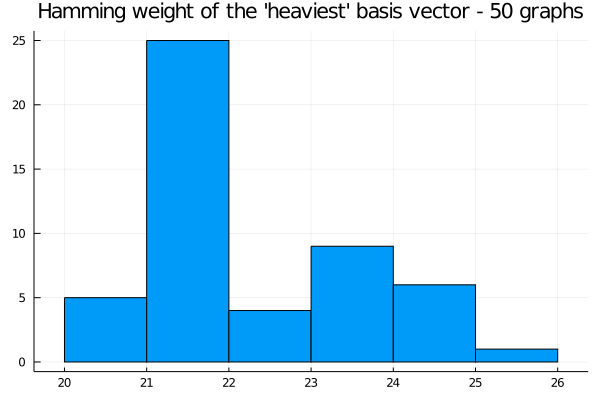

In [132]:
Plots.histogram(max_hws_, label="")
title!("Hamming weight of the 'heaviest' basis vector - $ngraphs graphs")

## 3. Monitor maximum Hamming weight for increasing size

In [144]:
ngraphs = 20
nn = 2 .^(6:12)
nsizes = length(nn)
R = 0.3
max_hws = zeros(nsizes, ngraphs)
sparsities = zeros(nsizes, ngraphs);

In [ ]:
for (i,n) in enumerate(nn)
    println("n=$n. Size $i of $nsizes")
    m = Int(round(n*(1-R)))
    @showprogress for g in 1:ngraphs
        max_hws[i,g], sparsities[i,g] = sparsity_and_hw(q, n, m, seed+g)
    end
end

n=64. Size 1 of 7
n=128. Size 2 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


n=256. Size 3 of 7


Progress: 100%|█████████████████████████████████████████| Time: 0:00:01


n=512. Size 4 of 7


Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:01

### Plot the average maximum HW as n increases

In [ ]:
# labels = hcat(["n="*string(n) for n in nn]...)
# histogram(permutedims(max_hws), layout=(ceil(Int, nsizes/3),3), label=labels, size=(800,400))

avg_max_hw = mean(max_hws, dims=2)
sd_max_hw = std(max_hws, dims=2) / sqrt(ngraphs)
Plots.plot(nn, avg_max_hw, yerr=sd_max_hw, marker=:circle, label="", xscale=:log10)
Plots.xlabel!("n"); Plots.ylabel!("HW"); 
Plots.title!("Hamming weight of 'heaviest' basis vector\nAverage over $(size(max_hws,2)) graphs")